In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib


import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [3]:
batch_size_train = 128
batch_size_test = 16
img_size = 32

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 104814743.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97847894.85it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28273943.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22307410.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([16, 1, 32, 32])


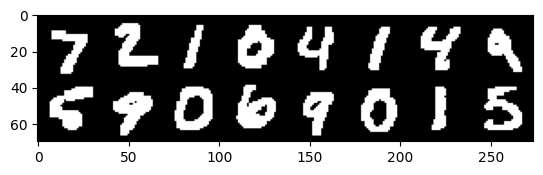

In [4]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(test_loader)
images, lables = next(dataiter)
print(images.shape)

imshow(torchvision.utils.make_grid(images))

In [5]:
# Architecture: LeNet
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.LeNet = nn.Sequential(
      nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2,2), stride = 2),
      nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2,2), stride = 2),
      nn.Flatten(),
      nn.Linear(in_features = 16 * 5 * 5, out_features = 120),
      nn.ReLU(),
      nn.Linear(in_features = 120, out_features = 84),
      nn.ReLU(),
      nn.Linear(in_features = 84, out_features = 10)
    )
  def forward(self, x):
    x = self.LeNet(x)
    return x



In [6]:

saved_params_path = "./saved_params_cnn"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

num_epochs = 30
lr = 3e-4

model = CNN().to(device)
print(model)

CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
  for batch_idx, (x, labels) in enumerate(train_loader, 0):
    x = x.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    output = model.forward(x)


    loss = CE_loss(output, labels)
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch+1}/{num_epochs}, Cross Entropy Loss: {loss.item():.2f}")
  torch.save(model.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(model.state_dict(), 'final_cnn.pth')

CNN(
  (LeNet): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)
Epoch 1/30, Cross Entropy Loss: 0.22
Epoch 2/30, Cross Entropy Loss: 0.04
Epoch 3/30, Cross Entropy Loss: 0.09
Epoch 4/30, Cross Entropy Loss: 0.01
Epoch 5/30, Cross Entropy Loss: 0.01
Epoch 6/30, Cross Entropy Loss: 0.04
Epoch 7/30, Cross Entropy Loss: 0.01
Epoch 8/30, Cross Entropy Loss: 0.06
Epoch 9/30, Cross Entropy Loss: 0.00
Epoch 10/30, Cross Entropy Loss: 0.01
Epoch 11/30

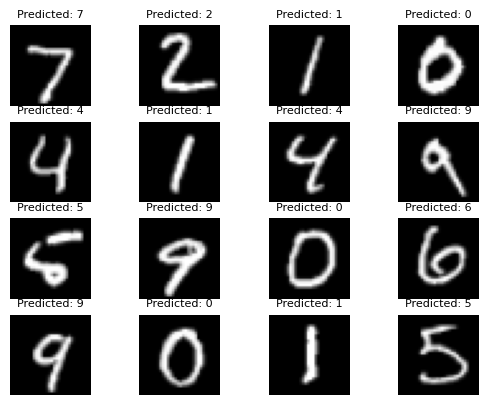

Accuracy : 98.74%


In [7]:
model.eval()

batch = next(iter(test_loader))
images, labels = batch

outputs = model(images.to(device))
_, prediction = torch.max(outputs.data, 1)

for i in range(16):
  image = images[i].numpy().squeeze()
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Predicted: {prediction[i]}', fontsize= 8)
  plt.axis('off')
plt.show()


with torch.no_grad():
  correct = 0
  total = 0
  for img, labels in test_loader:
    outputs = model(img.to(device))
    labels = labels.to(device)
    _, prediction = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (prediction == labels).sum().item()
  print(f'Accuracy : {100 * correct / total}%')

